In [30]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)  #The findFiles function uses glob.glob to find files matching a specified pattern.

print(findFiles('data.zip'))
!unzip data.zip

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):   #The unicodeToAscii function converts Unicode strings to ASCII, removing diacritics and non-ASCII characters.
    return ''.join(
        c for c in unicodedata.normalize('NFD', s) #Normalization form decomposition
        if unicodedata.category(c) != 'Mn' #The list comprehension filters out characters that are diacritical marks
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n') #The file is opened with UTF-8 encoding, read into a single string, stripped of leading and trailing whitespace, and split into lines.
    return [unicodeToAscii(line) for line in lines]  #returns the lines in ASCII format.

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)


[]
unzip:  cannot find or open data.zip, data.zip.zip or data.zip.ZIP.
Slusarski


In [31]:
all_categories

['Arabic',
 'Dutch',
 'Czech',
 'Japanese',
 'Vietnamese',
 'Portuguese',
 'Scottish',
 'Spanish',
 'Korean',
 'English',
 'Polish',
 'Irish',
 'Italian',
 'Russian',
 'German',
 'French',
 'Chinese',
 'Greek']

In [32]:
category_lines

{'Arabic': ['Khoury',
  'Nahas',
  'Daher',
  'Gerges',
  'Nazari',
  'Maalouf',
  'Gerges',
  'Naifeh',
  'Guirguis',
  'Baba',
  'Sabbagh',
  'Attia',
  'Tahan',
  'Haddad',
  'Aswad',
  'Najjar',
  'Dagher',
  'Maloof',
  'Isa',
  'Asghar',
  'Nader',
  'Gaber',
  'Abboud',
  'Maalouf',
  'Zogby',
  'Srour',
  'Bahar',
  'Mustafa',
  'Hanania',
  'Daher',
  'Tuma',
  'Nahas',
  'Saliba',
  'Shamoon',
  'Handal',
  'Baba',
  'Amari',
  'Bahar',
  'Atiyeh',
  'Said',
  'Khouri',
  'Tahan',
  'Baba',
  'Mustafa',
  'Guirguis',
  'Sleiman',
  'Seif',
  'Dagher',
  'Bahar',
  'Gaber',
  'Harb',
  'Seif',
  'Asker',
  'Nader',
  'Antar',
  'Awad',
  'Srour',
  'Shadid',
  'Hajjar',
  'Hanania',
  'Kalb',
  'Shadid',
  'Bazzi',
  'Mustafa',
  'Masih',
  'Ghanem',
  'Haddad',
  'Isa',
  'Antoun',
  'Sarraf',
  'Sleiman',
  'Dagher',
  'Najjar',
  'Malouf',
  'Nahas',
  'Naser',
  'Saliba',
  'Shamon',
  'Malouf',
  'Kalb',
  'Daher',
  'Maalouf',
  'Wasem',
  'Kanaan',
  'Naifeh',
  'Boutro

In [33]:
print(category_lines['Italian'][:5])


['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [34]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [47]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super(RNN,self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.W_ih = nn.Parameter(torch.randn(self.hidden_size,self.input_size))
    self.W_hh = nn.Parameter(torch.randn(self.hidden_size,self.hidden_size))
    self.W_ho = nn.Parameter(torch.randn(self.output_size,self.hidden_size))
    self.b_h = nn.Parameter(torch.zeros(self.hidden_size))
    self.b_o = nn.Parameter(torch.zeros(self.output_size))

  def forward(self, input, hidden, time_steps=10):
    if not torch.is_tensor(input) or not torch.is_tensor(hidden):
      raise ValueError("Input and hidden must be tensors")

    input = input.view(-1, self.input_size)
    hidden = torch.tanh(input @ self.W_ih.t() + hidden @ self.W_hh.t() + self.b_h)
    output = F.log_softmax(hidden @ self.W_ho.t() + self.b_o,dim=1)
    return output,hidden

  def initHidden(self, batch_size=1):
    return torch.zeros(batch_size, self.hidden_size)


input_size = n_letters
hidden_size = n_hidden =  8
output_size = n_categories
rnn = RNN(input_size, hidden_size, output_size)

In [48]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

print(output,next_hidden)

tensor([[-3.2690, -3.2725, -0.2954, -5.6066, -6.3152, -5.9542, -6.2278, -5.1751,
         -5.1105, -3.9986, -4.6151, -4.7395, -6.4912, -2.4431, -5.1547, -4.9702,
         -4.8631, -4.4026]], grad_fn=<LogSoftmaxBackward0>) tensor([[ 0.9800,  0.7529,  0.6628, -0.4758,  0.9733,  0.2012, -0.6877,  0.9025]],
       grad_fn=<TanhBackward0>)


In [49]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-3.2690, -3.2725, -0.2954, -5.6066, -6.3152, -5.9542, -6.2278, -5.1751,
         -5.1105, -3.9986, -4.6151, -4.7395, -6.4912, -2.4431, -5.1547, -4.9702,
         -4.8631, -4.4026]], grad_fn=<LogSoftmaxBackward0>)


In [50]:
def categoryFromOutput(output):
    # Get the top category index from the model's output
    top_n, top_i = output.topk(1)  # Returns the highest value and its index
    category_i = top_i[0].item()   # Convert the top index tensor to a Python integer
    return all_categories[category_i], category_i  # Return the category name and its index

# Example usage: print the category name and index for the given output
print(categoryFromOutput(output))


('Czech', 2)


In [51]:
import random

# Function to choose a random element from a list ``l``
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Function to create a random training example
def randomTrainingExample():
    # Choose a random category (language)
    category = randomChoice(all_categories)

    # Choose a random line (name) from the chosen category
    line = randomChoice(category_lines[category])

    # Create a tensor for the category (as an index in all_categories)
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)

    # Convert the line to a tensor using the lineToTensor function
    line_tensor = lineToTensor(line)

    # Return the category, line, and their respective tensors
    return category, line, category_tensor, line_tensor

# Loop to print 10 random training examples
for i in range(10):
    # Get a random training example
    category, line, category_tensor, line_tensor = randomTrainingExample()

    # Print the category and line
    print('category =', category, '/ line =', line)


category = French / line = Boucher
category = Dutch / line = Rooiakkers
category = English / line = Kilb
category = Japanese / line = Fukuyama
category = Vietnamese / line = Dam
category = Scottish / line = Wood
category = Greek / line = Close
category = Vietnamese / line = Ha
category = Spanish / line = Montero
category = German / line = Warner


In [52]:
criterion = nn.NLLLoss()

In [53]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate (this is done instead of optimizer.step())
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [54]:
import time
import math

# Number of iterations to train
n_iters = 100000

# Print progress every ``print_every`` iterations
print_every = 5000

# Record loss for plotting every ``plot_every`` iterations
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

# Function to calculate the elapsed time since ``since`` in minutes and seconds
def timeSince(since):
    now = time.time()  # Current time
    s = now - since  # Elapsed time in seconds
    m = math.floor(s / 60)  # Convert seconds to minutes
    s -= m * 60  # Remaining seconds after converting to minutes
    return '%dm %ds' % (m, s)  # Format as "Xm Ys"

start = time.time()  # Record the start time

for iter in range(1, n_iters + 1):
    # Get a random training example: category, line, and their tensor representations
    category, line, category_tensor, line_tensor = randomTrainingExample()

    # Train the model on the example and get the output and loss
    output, loss = train(category_tensor, line_tensor)

    current_loss += loss  # Accumulate the loss

    # Print ``iter`` number, loss, name and guess every ``print_every`` iterations
    if iter % print_every == 0:
        # Get the model's guess and the index of the guessed category
        guess, guess_i = categoryFromOutput(output)

        # Check if the guess is correct
        correct = '✓' if guess == category else '✗ (%s)' % category

        # Print iteration number, progress, elapsed time, loss, input line, guessed category, and correctness
        print('%d %d%% (%s) %.4f %s / %s %s' % (
            iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss average to the list of losses every ``plot_every`` iterations
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)  # Average loss over the last ``plot_every`` iterations
        current_loss = 0  # Reset current loss


5000 5% (0m 9s) 2.6505 Barros / Japanese ✗ (Spanish)
10000 10% (0m 18s) 4.1469 Autenburg / Czech ✗ (German)
15000 15% (0m 27s) 2.0202 Kalandarov / Russian ✓
20000 20% (0m 36s) 1.4121 Ajello / Italian ✓
25000 25% (0m 46s) 2.3749 Itami / Italian ✗ (Japanese)
30000 30% (0m 55s) 3.3431 Quach / Irish ✗ (Vietnamese)
35000 35% (1m 3s) 2.2082 Larue / Greek ✗ (French)
40000 40% (1m 12s) 2.2428 Dolcy / Russian ✗ (English)
45000 45% (1m 22s) 4.2720 Abadi / Italian ✗ (Arabic)
50000 50% (1m 31s) 5.1926 Zee / Vietnamese ✗ (Dutch)
55000 55% (1m 39s) 0.5045 Yu / Korean ✓
60000 60% (1m 49s) 1.2745 Gil / Chinese ✗ (Korean)
65000 65% (1m 58s) 3.7964 Karube / Greek ✗ (Japanese)
70000 70% (2m 6s) 2.8004 Hadad / Irish ✗ (Arabic)
75000 75% (2m 15s) 1.0065 Jing / Chinese ✓
80000 80% (2m 24s) 0.9344 Haradurov / Russian ✓
85000 85% (2m 33s) 2.4889 Geissler / Greek ✗ (German)
90000 90% (2m 42s) 1.5379 Byon / Korean ✓
95000 95% (2m 51s) 1.4460 Amantea / Portuguese ✗ (Italian)
100000 100% (3m 0s) 2.2933 Nichol / S

<ipython-input-55-00c85b34ed22>:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)  # Set x-axis labels with rotation
<ipython-input-55-00c85b34ed22>:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)  # Set y-axis labels


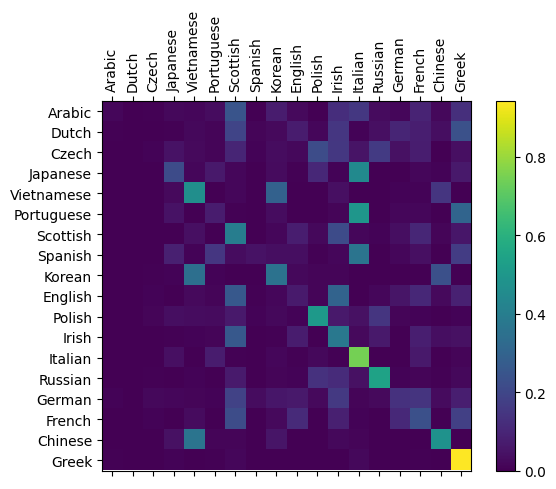

In [55]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)  # Initialize an empty confusion matrix
n_confusion = 10000  # Number of examples to evaluate for the confusion matrix

import matplotlib.pyplot as plt  # Importing matplotlib for plotting
import matplotlib.ticker as ticker  # Importing ticker for customizing ticks

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()  # Initialize the hidden state

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)  # Pass each character in the line through the RNN

    return output  # Return the final output of the RNN

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()  # Get a random training example
    output = evaluate(line_tensor)  # Evaluate the line tensor
    guess, guess_i = categoryFromOutput(output)  # Get the guessed category and its index
    category_i = all_categories.index(category)  # Get the true category index
    confusion[category_i][guess_i] += 1  # Increment the corresponding cell in the confusion matrix

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()  # Normalize each row

# Set up plot
fig = plt.figure()  # Create a new figure
ax = fig.add_subplot(111)  # Add a subplot to the figure
cax = ax.matshow(confusion.numpy())  # Display the confusion matrix as an image
fig.colorbar(cax)  # Add a color bar to the figure

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)  # Set x-axis labels with rotation
ax.set_yticklabels([''] + all_categories)  # Set y-axis labels

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))  # Set x-axis major ticks
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))  # Set y-axis major ticks
plt.show()  # Show the plot

In [56]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])


In [57]:
predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-1.39) Russian
(-1.68) Czech
(-1.81) Polish

> Jackson
(-1.75) Irish
(-1.89) English
(-2.24) French

> Satoshi
(-1.14) Italian
(-1.67) Japanese
(-1.92) Spanish
